# **Clustering (from scratch)**

This tutorial will guide you through the implementation of **K-means** and **DBSCAN** clustering algorithms in Python. While scikit-learn is a useful tool for utilizing clustering algorithms, it is largely a black box that does not help you gain a deeper understanding of the concepts covered in the lecture.

Therefore, we will use only NumPy. By implementing K-means and DBSCAN from scratch, you will have a better understanding of the underlying concepts behind them and how they work.

Let's first import some libraries:

In [ ]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import load_iris

# **Dataset**

For the first part of this tutorial, we will use the well-known [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) for this tutorial. The dataset includes 50 samples from each of three species of Iris (Iris setosa, Iris virginica, and Iris versicolor). Four features were measured from each sample, i.e. the length and width of the sepals and petals in centimeters.

To make the input space easier to plot, we will only consider two features (i.e. petal length and width).

Let's load and print the data:

In [ ]:
iris = load_iris()
iris_df = pd.DataFrame(
    data=np.c_[iris["data"], iris["target"]],
    columns=iris["feature_names"] + ["target"]
)

# Select only 2 features
iris_df = iris_df[["petal length (cm)", "petal width (cm)", "target"]]

iris_df.head()

,petal length (cm),petal width (cm),target
0,1.4,0.2,0.0
1,1.4,0.2,0.0
2,1.3,0.2,0.0
3,1.5,0.2,0.0
4,1.4,0.2,0.0


We now convert the data into NumPy variables:

In [ ]:
X = iris_df[["petal length (cm)", "petal width (cm)"]].to_numpy()
y = iris_df[["target"]].to_numpy().ravel().astype(np.int32)

We also define a function that plots the data:

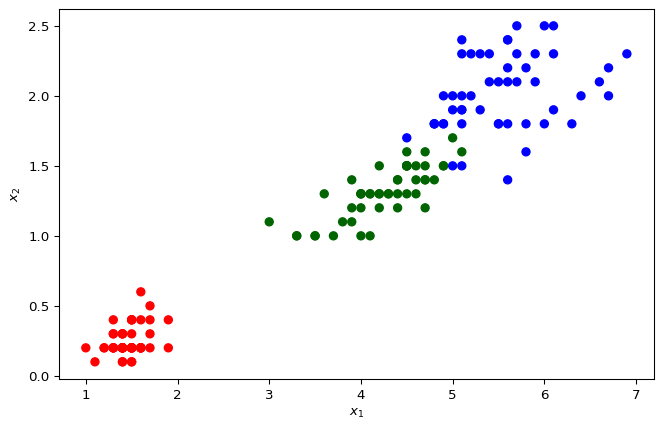

In [ ]:
def plot_data(
    X, y, model=None, plot_boundaries=False,
    plot_centroids=False, plot_clusters=False,
    xlabel="$x_1$", ylabel="$x_2$",
):

    # Hyperparameter for mesh grid
    X1_min = X[:, 0].min() - 0.5
    X1_max = X[:, 0].max() + 0.5
    X2_min = X[:, 1].min() - 0.5
    X2_max = X[:, 1].max() + 0.5
    step = 0.01

    xx1, xx2 = np.meshgrid(
        np.arange(X1_min, X1_max, step),
        np.arange(X2_min, X2_max, step),
    )
    if plot_boundaries:
        z = model.predict(np.column_stack([xx1.ravel(), xx2.ravel()]))
        z = z.reshape(xx1.shape)

    # Create color maps for 3 classes
    cmap_light = ListedColormap(["#FFE033", "#BE12F5", "#04F1F1"])
    cmap_bold = ListedColormap(["#FF0000", "#006400", "#0000FF"])

    plt.figure(figsize=(8, 5), dpi=96)

    if plot_boundaries:
        plt.pcolormesh(xx1, xx2, z, cmap=cmap_light, alpha=0.5)

    if plot_centroids:
        if hasattr(model, "cluster_centers_"):
            centroids = model.cluster_centers_
        elif hasattr(model, "centroids_"):
            centroids = model.centroids_
        else:
            raise RuntimeError(
                "No `cluster_centers_` nor `centroids_` attribute found"
            )
        plt.scatter(
          centroids[:, 0],
          centroids[:, 1],
          marker="x",
          s=169,
          linewidths=3,
          color="w",
          zorder=10,
      )

    if plot_clusters:
        if hasattr(model, "labels_"):
            labels = model.labels_
        else:
            raise RuntimeError(
                "No `labels_` attribute found"
            )
        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Black used for noise
                col = [0, 0, 0, 1]

            class_member_mask = labels == k

            xy = X[class_member_mask]
            plt.plot(
                xy[:, 0],
                xy[:, 1],
                "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=8,
            )

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

plot_data(X, y)

## **K-means**

K-means is a popular clustering algorithm used to partition a dataset into $K$ distinct, non-overlapping clusters. The algorithm can be summarized in the following steps:

1. Choose the number of clusters $K$ and **randomly initialize $K$ centroids**;
2. Assign each data point to the **nearest centroid**;
3. Recalculate the centroids of each cluster as the **mean of all data points assigned to that cluster**;
4. **Repeat steps 2 and 3** until convergence is achieved.

The K-means algorithm is a simple, yet powerful technique for clustering large datasets. However, **$K$ must be chosen in advance**, it is sensitive to the **centroid initialization**, it may converge to **local minima** and it assumes **isotropic clusters of equal size**. In particular, as we will see in this tutorial, it cannot deal with non-spherical clusters.

Implementation of K-means is straightforward. We will put the code for training in  `fit` and the code for making a prediction in `predict`:

In [ ]:
# Adapted from:
# https://github.com/eriklindernoren/ML-From-Scratch/blob/master/mlfromscratch/unsupervised_learning/k_means.py

class MyKMeans:
    def __init__(self, n_clusters=2, max_iter=500, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self._np_random = np.random.default_rng(random_state)
        self.centroids_ = self._init_random_centroids(X)

    def _init_random_centroids(self, X):
        n_samples, n_features = np.shape(X)
        centroids = np.zeros((self.n_clusters, n_features))
        for i in range(self.n_clusters):
            centroid = X[self._np_random.choice(range(n_samples))]
            centroids[i] = centroid
        return centroids

    def _get_closest_centroid(self, sample, centroids):
        # Return the index of the closest centroid to the sample
        closest_i = 0
        closest_dist = float("inf")
        for i, centroid in enumerate(centroids):
            distance = np.sqrt(((sample - centroid) ** 2).sum())
            if distance < closest_dist:
                closest_i = i
                closest_dist = distance
        return closest_i

    def _create_clusters(self, centroids, X):
        # Assign the samples to the closest centroids to create clusters
        n_samples = np.shape(X)[0]
        clusters = [[] for _ in range(self.n_clusters)]
        for sample_i, sample in enumerate(X):
            centroid_i = self._get_closest_centroid(sample, centroids)
            clusters[centroid_i].append(sample_i)
        return clusters

    def _calculate_centroids(self, clusters, X):
        # Calculate new centroids as the means of the samples in each cluster
        n_features = np.shape(X)[1]
        centroids = np.zeros((self.n_clusters, n_features))
        for i, cluster in enumerate(clusters):
            centroid = np.mean(X[cluster], axis=0)
            centroids[i] = centroid
        return centroids

    def _get_cluster_labels(self, clusters, X):
        # Classify samples as the index of their clusters
        # One prediction for each sample
        y_pred = np.zeros(np.shape(X)[0])
        for cluster_i, cluster in enumerate(clusters):
            for sample_i in cluster:
                y_pred[sample_i] = cluster_i
        return y_pred

    def fit(self, X):
        # Initialize centroids as n_clusters random samples from X
        centroids = self._init_random_centroids(X)

        # Iterate until convergence or for max iterations
        for _ in range(self.max_iter):
            # Assign samples to closest centroids (create clusters)
            clusters = self._create_clusters(centroids, X)
            # Save current centroids for convergence check
            prev_centroids = centroids
            # Calculate new centroids from the clusters
            centroids = self._calculate_centroids(clusters, X)
            # If no centroids have changed => convergence
            diff = centroids - prev_centroids
            if not diff.any():
                break

        self.centroids_ = centroids
        return self

    def predict(self, X):
        # Assign samples to closest centroids (create clusters)
        clusters = self._create_clusters(self.centroids_, X)
        return self._get_cluster_labels(clusters, X)

Now we can train K-means and plot the clusters:


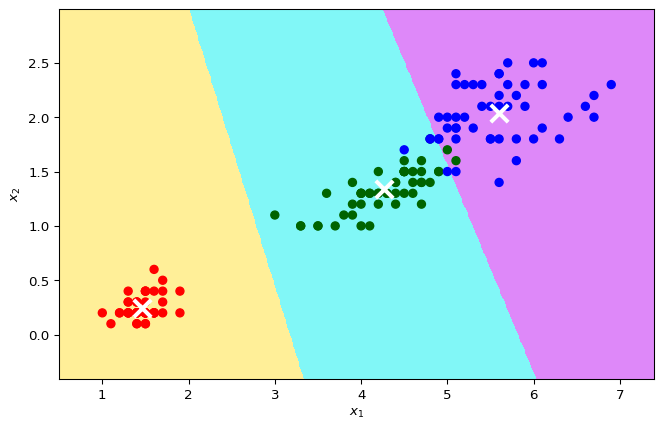

In [ ]:
my_kmeans = MyKMeans(n_clusters=3, max_iter=300, random_state=0).fit(X)
plot_data(X, y, model=my_kmeans, plot_boundaries=True, plot_centroids=True)

The resulting plot is a [Voronoi diagram](https://en.wikipedia.org/wiki/Voronoi_diagram). For verification, let's compare it with the model learned by scikit-learn:

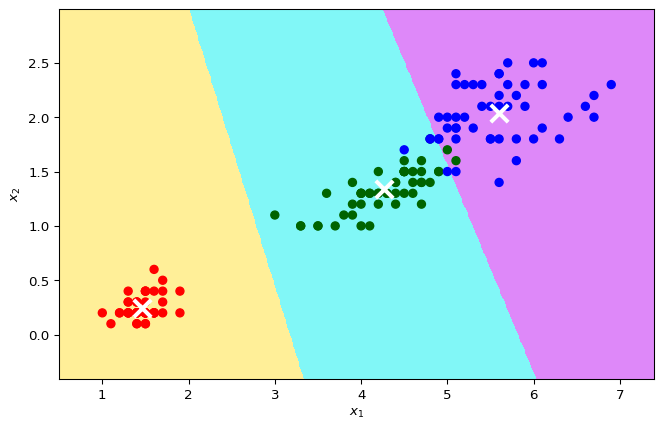

In [ ]:
from sklearn.cluster import KMeans


sklearn_kmeans = KMeans(n_clusters=3, max_iter=300, n_init="auto", random_state=0).fit(X)
plot_data(X, y, model=sklearn_kmeans, plot_boundaries=True, plot_centroids=True)

What happens if the clusters are non-spherical? Let's try with two ellipses one inside the other:

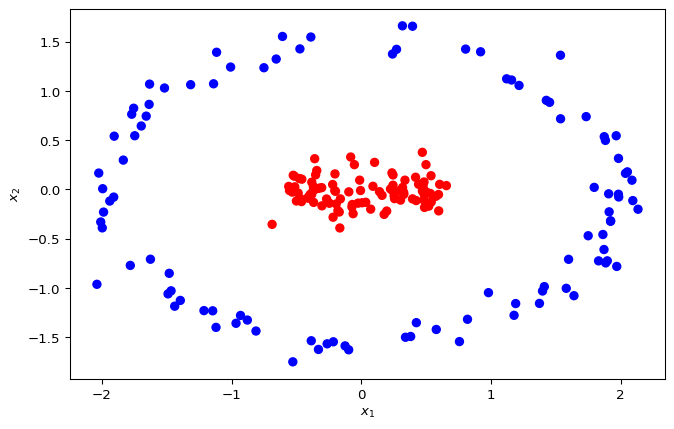

In [ ]:
def elipse_samples(N, u=1, v=0.5, a=2., b=1.5, sigma_noise=0.1, random_state=None):
    """Draws data from an elipse function (by addding a small noise)

    Arguments:
    N (int): Number of data points to sample
    u (float): x-position of the center
    v (float): y-position of the center
    a (float): radius on the x-axis
    b (float): radius on the y-axis
    sigma_noise: standard deviation applied to the additive noise
    random_state: the random state for reproducibility

    Returns
    x (np.array): samples drawn from the ellipse
    """
    np_random = np.random.default_rng(random_state)
    t = np_random.uniform(low=0.0, high=2 * math.pi, size=N)
    x1 = u + a * np.cos(t) + np_random.normal(loc=0.0, scale=sigma_noise, size=N)
    x2 = v + b * np.sin(t) + np_random.normal(loc=0.0, scale=sigma_noise, size=N)
    return np.stack([x1, x2]).T


def get_dataset(
    N=100,
    mu0=np.array([0, 0]),
    cov0=np.array([[0.5, 0], [0, 0.5]]),
    mu1=np.array([2, 2]),
    cov1=np.array([[0.5, 0], [0, 0.5]]),
    sigma_noise=0.1,
    random_state=None,
):
    """Creates data for binary classification by drawing samples from the ellipse"""
    # Class 0 samples
    x0 = elipse_samples(
        N, u=0, v=0, a=2.0, b=1.5,
        sigma_noise=sigma_noise, random_state=random_state,
    )
    y0 = np.ones(x0.shape[0])

    # Class 1 samples
    x1 = elipse_samples(
        N, u=0, v=0, a=0.5, b=0.1,
        sigma_noise=sigma_noise, random_state=random_state,
    )
    y1 = -np.ones(x1.shape[0])

    X = np.concatenate([x0, x1])
    y = np.concatenate([y0, y1])
    return X, y


X, y = get_dataset(random_state=0)
plot_data(X, y)

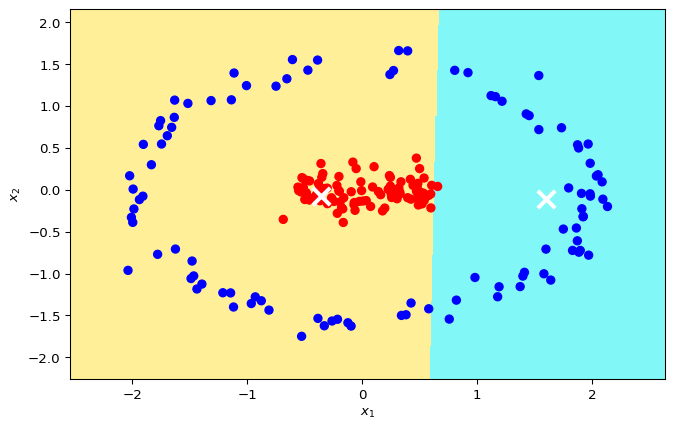

In [ ]:
my_kmeans = MyKMeans(n_clusters=2, max_iter=300, random_state=0).fit(X)
plot_data(X, y, model=my_kmeans, plot_boundaries=True, plot_centroids=True)

As expected, K-means fails to find meaningful patterns in the data since the clusters are non-spherical. DBSCAN is a popular alternative that can handle such cases.

## **DBSCAN**

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a clustering algorithm that groups points that are closely packed together in high-density regions. The key idea is to define a neighborhood around each point and identify clusters based on the density of points within that neighborhood. Points that are not part of any cluster are marked as noise.  The algorithm can be summarized in the following steps:

1. Set the hyperparameters `eps` (the distance threshold) and `min_samples` (the minimum number of points per cluster);
2. Select a point from the dataset that has not been visited yet;
3. Retrieve all points **within distance `eps`** from the selected point, forming a cluster;
4. Expand the cluster by **recursively adding neighboring points** that are also within distance `eps` from the cluster;
5. If the size of the cluster is less than `min_samples`, mark it as noise;
6. **Recurse to step 2** until all points have been visited.

DBSCAN does not require the number of clusters to be specified beforehand, it can identify clusters of arbitrary shapes, and it is robust to outliers. However, it is sensitive to the choice of `eps` and `min_samples`, it does not work well with high-dimensional data and it is inefficient for large datasets.

Note that, since DBSCAN is density based, **decision boundaries are not defined** and thus **it cannot be used to assign a cluster label to a new previously unseen point** (you need to add each new point to the training set and refit the algorithm). Furthermore, it doesn't have a `random_state` as it is completely deterministic (given fixed data, `eps`, `min_samples`, distance metric and iteration order).

Implementation of DBSCAN is more challenging than K-means. We will put the code for training in `fit` (as mentioned above, `predict` is not defined):

In [ ]:
# Adapted from:
# https://github.com/eriklindernoren/ML-From-Scratch/blob/master/mlfromscratch/unsupervised_learning/dbscan.py

class MyDBSCAN():
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.labels_ = None

    def _get_neighbors(self, sample_i):
        # Return a list of indexes of neighboring samples
        # A sample_2 is considered a neighbor of sample_1 if the distance between
        # them is smaller than epsilon
        neighbors = []
        idxs = np.arange(len(self.X))
        for i, _sample in enumerate(self.X[idxs]):
            distance = np.sqrt(((self.X[sample_i] - _sample) ** 2).sum())
            if distance < self.eps:
                neighbors.append(i)
        return np.array(neighbors)

    def _expand_cluster(self, sample_i, neighbors):
        # Recursive method which expands the cluster until we have reached the border
        # of the dense area (density determined by eps and min_samples)
        cluster = [sample_i]
        # Iterate through neighbors
        for neighbor_i in neighbors:
            if not neighbor_i in self.visited_samples:
                self.visited_samples.append(neighbor_i)
                # Fetch the sample's distant neighbors (neighbors of neighbor)
                self.neighbors[neighbor_i] = self._get_neighbors(neighbor_i)
                # Make sure the neighbor's neighbors are more than min_samples
                # (If this is true the neighbor is a core point)
                if len(self.neighbors[neighbor_i]) >= self.min_samples:
                    # Expand the cluster from the neighbor
                    expanded_cluster = self._expand_cluster(
                        neighbor_i, self.neighbors[neighbor_i])
                    # Add expanded cluster to this cluster
                    cluster = cluster + expanded_cluster
                else:
                    # If the neighbor is not a core point we only add the neighbor point
                    cluster.append(neighbor_i)
        return cluster

    def _get_cluster_labels(self):
        # Return the samples labels as the index of
        # the cluster in which they are contained
        # Set default value to -1 (=> noise)
        labels = np.full(shape=self.X.shape[0], fill_value=-1)
        for cluster_i, cluster in enumerate(self.clusters):
            for sample_i in cluster:
              labels[sample_i] = cluster_i if len(cluster) >= self.min_samples else -1
        return labels

    def fit(self, X):
        self.X = X
        self.clusters = []
        self.visited_samples = []
        self.neighbors = {}
        n_samples = np.shape(self.X)[0]
        # Iterate through samples and expand clusters from them
        # if they have more neighbors than self.min_samples
        for sample_i in range(n_samples):
            if sample_i in self.visited_samples:
                continue
            self.neighbors[sample_i] = self._get_neighbors(sample_i)
            if len(self.neighbors[sample_i]) >= self.min_samples:
                # If core point => mark as visited
                self.visited_samples.append(sample_i)
                # Sample has more neighbors than self.min_samples => expand
                # cluster from sample
                new_cluster = self._expand_cluster(
                    sample_i, self.neighbors[sample_i]
                )
                # Add cluster to list of clusters
                self.clusters.append(new_cluster)

        # Get the resulting cluster labels
        cluster_labels = self._get_cluster_labels()
        self.labels_ = cluster_labels
        return self

Now we can train DBSCAN and plot the clusters (noisy samples are black, if any):

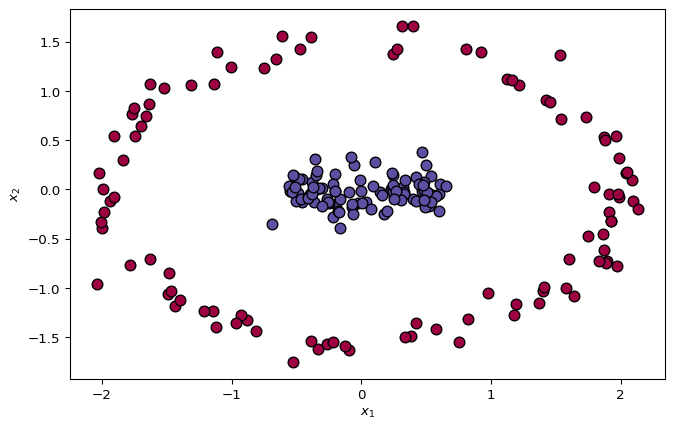

In [ ]:
my_dbscan = MyDBSCAN(eps=0.6, min_samples=5).fit(X)
plot_data(X, y, model=my_dbscan, plot_clusters=True)

For verification, let's compare it with the model learned by scikit-learn:

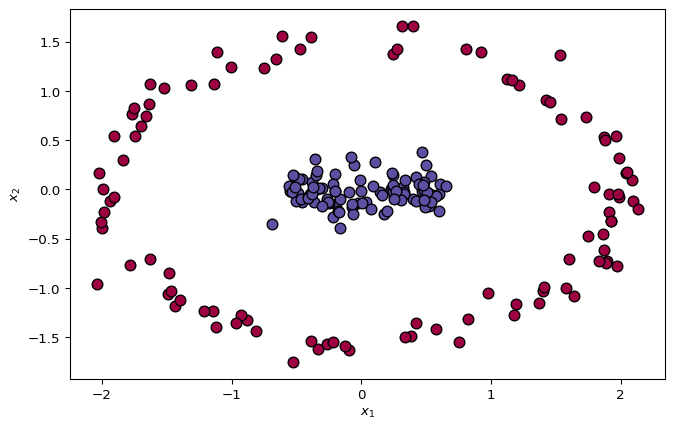

In [ ]:
from sklearn.cluster import DBSCAN


sklearn_dbscan = DBSCAN(eps=0.6, min_samples=5).fit(X)
plot_data(X, y, model=sklearn_dbscan, plot_clusters=True)

As expected, DBSCAN is able to correctly identify the clusters. However, hyperparameter tuning is crucial. Feel free to play with `eps` and `min_samples` to see how the result changes dramatically.

That's all!